<h1> Setup </h1>


In [98]:
import matplotlib.pyplot as plt
import awkward as ak
import dask_awkward as dak
import numpy as np
import uproot
from hist import Hist, axis
import os

#Constants
current_dir = os.getcwd()
tree_name= "Delphes"  #all of them are named delphes
luminescence = 300 #fb

#Signal
signal_crossSection = 0.0018 * 1000 #times 1000 to convert from pb to fb

signal_folder = "Signals_DMSimpl_Spin0/"
signal_filename =  "VBF_DM_My0_1000_MXD_10.root"
signal_filepath = signal_folder +signal_filename
signal_file = uproot.open(signal_folder +signal_filename)


#Background
background_folders = {"BKG_Wjets_WToLNu" : 47744.85 * 1000,
                       "BKG_Zjets_ZToNuNu": 8818.65 * 1000}  #foldername, significance



     #all this is temp for now
#will store data to be used in final "cut chart"
num_cuts = 5
SM_events = [1000,700,200]
NP_events = [500,400,300]
Significance = [1,2.4,5]
   


<h2> Bins </h2>

In [99]:
binning = {
    "PT": {"range": (20, 1000), "bins": 14},  # (300 - 20) / 20 = 14 bins
    "Eta*Eta": {"range": (-25, 25), "bins": 500},  # (25 - (-25)) / 0.1 = 500 bins
    "Delta_Eta": {"range": (0, 10), "bins": 100},  # (10 - 0) / 0.1 = 100 bins
    "Transverse": {"range": (0, 500), "bins": 100},  # (2000 - 500) / 20 = 75 bins
    "Eta": {"range": (-5, 5), "bins": 100},  # (5 - (-5)) / 0.1 = 100 bins
    "Phi": {"range": (-(np.pi), np.pi), "bins": 63},  
    "Invariant": {"range": (50, 3000), "bins": 148}  # (3000 - 50) / 20 = 147.5, rounded to 148 bins
}



<h2> Functions </h2>

<h4>Calculations </h4>

In [100]:
def calculateWeight(num_events, effective_area, lumi):
    return effective_area * lumi / num_events

def calculateSignificance(numSig,numBkg):
    return numSig/np.sqrt(numSig + numBkg)

<h4> Tree Functions </h4>

In [101]:
def openTree(tree_filepath):
    #Open tree and only keep stuff that we need
    
    file = uproot.open(tree_filepath)
    tree = file[tree_name]

    #What we want to keep
    branches_wanted = [
        "MissingET.MET",
        "MissingET.Phi",
        "Jet.PT",
        "Jet.Phi",
        "Jet.Eta",
        "Jet.Mass"
    ]
    df = tree.arrays(branches_wanted,library="pd")

    return df

In [102]:
def applySingleCut(df, mask_function):
    mask = mask_function(df)
    return df[mask]


In [103]:
def applyMultipleCuts(df, mask_functions):
    
    for mask in mask_functions:
        df = applySingleCut(df, mask)

    return df

<h4> Calculate All Weights </h4>

In [104]:
#Signal Weights
sig_df = openTree(signal_filepath)
signal_temp = sig_df["MissingET.MET"].values #arbitraty branch
numSigEvents = len(signal_temp)
signal_weight = calculateWeight(num_events=numSigEvents, effective_area=signal_crossSection, lumi=luminescence)

background_weight_list = []
for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)

        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:
            cross_section = background_folders[folder_name]

            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_df = openTree(file_path) 
                    background_temp = background_df["MissingET.MET"].values #arbitraty branch 

                    numBkgEvents = len(background_df)
                    tempBkgWeight = calculateWeight(num_events=numBkgEvents, effective_area=cross_section, lumi=luminescence)

                    background_weight_list.append(tempBkgWeight)

In [105]:
def getJetsData(dataname, masklist): 
    #used when we are working with J0,J1 stuff (which is alot)
    
    #Get Signal Data
    df = openTree(signal_filepath)
    print("Num Sig Events before Mask",df.shape[0])

    if(masklist is not None):
        df = applyMultipleCuts(df, masklist)
        print("Num Sig Events AFTER Mask",df.shape[0])
    
    # Extract signal jet data
    signal_jets = df["Jet." + dataname].values
    signal_filtered_jets = [entry for entry in signal_jets if len(entry) >= 2]  # At least two entries
    signal_j0 = np.array([entry[0] for entry in signal_filtered_jets])
    signal_j1 = np.array([entry[1] for entry in signal_filtered_jets])


    # Background processing
    background_j0_list = []
    background_j1_list = []

    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)

        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:

            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_df = openTree(file_path)  

                    if(masklist is not None):
                        background_df = applyMultipleCuts(background_df, masklist)

                    # Extract and filter jet data
                    background_jets = background_df["Jet." + dataname].values
                    background_filtered_jets = [entry for entry in background_jets if len(entry) >= 2]  # At least two entries

                    # Extract J0 and J1
                    background_j0 = np.array([entry[0] for entry in background_filtered_jets])
                    background_j1 = np.array([entry[1] for entry in background_filtered_jets])

                  
                    background_j0_list.append(background_j0)
                    background_j1_list.append(background_j1)

    return signal_j0, signal_j1, background_j0_list, background_j1_list

In [106]:
def PlotJets(binname,dataname,masklist):
    j0_hist_background = Hist(
            axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
        )
    j0_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J0")
    )

    #J1
    j1_hist_background = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )
    j1_hist_signal = Hist(
        axis.Regular(binning[binname]["bins"], *binning[binname]["range"], name="thedata", label=dataname+"J1")
    )

    j0sig, j1sig, bkgj0list, bkgj1list,  = getJetsData(dataname,masklist)

    j0_hist_signal.fill(thedata=j0sig, weight=signal_weight)
    j1_hist_signal.fill(thedata=j1sig, weight=signal_weight)


    for i in range(len(background_weight_list)):
        j0_hist_background.fill(thedata=bkgj0list[i], weight=background_weight_list[i])
        j1_hist_background.fill(thedata=bkgj1list[i], weight=background_weight_list[i])
    

    # Create a figure and a set of subplots (2 columns, 1 row)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot J0
    axs[0].stairs(
        j0_hist_background.values(),
        j0_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[0].stairs(
        j0_hist_signal.values(),
        j0_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[0].set_xlabel(dataname+'(j0)')
    axs[0].set_ylabel('Counts')
    axs[0].set_yscale('log')
    axs[0].set_title(dataname+'(j0) Distributions')
    axs[0].legend()
    axs[0].grid(True)

    # Plot J1
    axs[1].stairs(
        j1_hist_background.values(),
        j1_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )
    axs[1].stairs(
        j1_hist_signal.values(),
        j1_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )
    axs[1].set_xlabel(dataname+'(j1)')
    axs[1].set_ylabel('Counts')
    axs[1].set_yscale('log')
    axs[1].set_title(dataname+'(j1) Distributions')
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

<h1> Plot Everything</h1>

<h3> MET <h3>

In [107]:
def PlotMET(masklist):
    met_hist_background = Hist(
        axis.Regular(binning["Transverse"]["bins"], *binning["Transverse"]["range"], name="MET", label="MET")
    )
    met_hist_signal = Hist(
        axis.Regular(binning["Transverse"]["bins"], *binning["Transverse"]["range"], name="MET", label="MET")
    )

    #Signal Data
    tree_df = openTree(signal_filepath)

    if(masklist is not None):
        tree_df = applyMultipleCuts(tree_df, masklist)

    signal_met = tree_df["MissingET.MET"].values
    signal_met = ak.flatten(signal_met).to_numpy()


    met_hist_signal.fill(MET=signal_met,weight = signal_weight)

    #Background
    counter = 0
    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)
            
        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:
            
            
            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_df = openTree(file_path)

                    if(masklist is not None):
                        background_df = applyMultipleCuts(background_df, masklist)

                    background_met = background_df["MissingET.MET"].values
                    background_met = ak.flatten(background_met).to_numpy()
                   
                    met_hist_background.fill(MET=background_met,weight =background_weight_list[counter])
                    counter+=1
                
                    




    #Set up histogram
    plt.figure(figsize=(10, 6))

    # Background histogram
    plt.stairs(
        met_hist_background.values(),
        met_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )

    # Signal histogram
    plt.stairs(
        met_hist_signal.values(),
        met_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )

    # Add labels and legend
    plt.xlabel('MET')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.title('MET Distribution')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

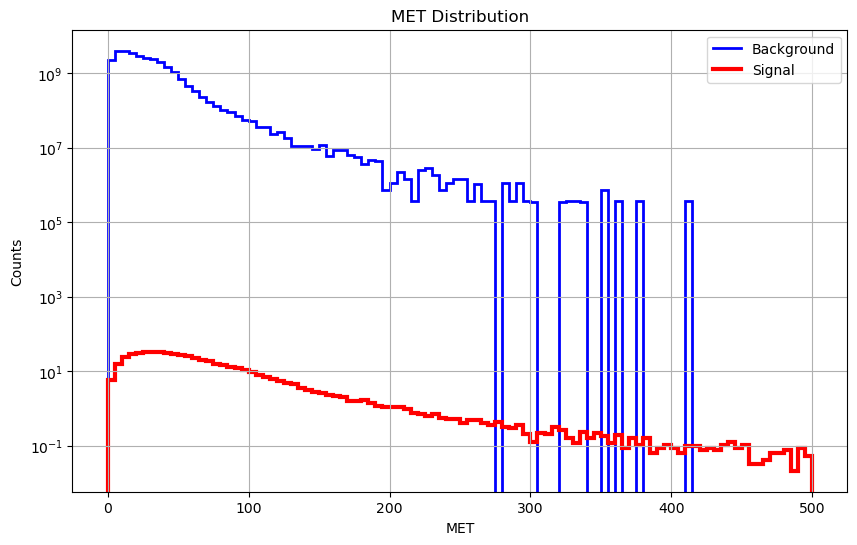

In [108]:
PlotMET(None)

<h3> Phi(Met) </h3>

In [109]:
def PlotPhiMet(masklist):

    met_phi_hist_background = Hist(
        axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
    )
    met_phi_hist_signal = Hist(
        axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
    )


    #Signal Data
    tree_df = openTree(signal_filepath)

    if(masklist is not None):
        tree_df = applyMultipleCuts(tree_df, masklist)

    signal_met_phi = tree_df["MissingET.Phi"].values
    signal_met_phi = ak.flatten(signal_met_phi).to_numpy()

    met_phi_hist_signal.fill(MET_Phi=signal_met_phi,weight = signal_weight)

    #Background
    counter = 0
    for folder_name in os.listdir(current_dir):
        folder_path = os.path.join(current_dir, folder_name)
            
        # Check if the current item is a directory and if its name is in the background_folders dictionary
        if os.path.isdir(folder_path) and folder_name in background_folders:
            cross_section = background_folders[folder_name]
            
            for root_file in os.listdir(folder_path):
                if root_file.endswith(".root"):
                    file_path = os.path.join(folder_path, root_file)
                    background_df = openTree(file_path)

                    if(masklist is not None):
                        background_df = applyMultipleCuts(background_df, masklist)

                    background_met_phi = background_df["MissingET.Phi"].values
                    background_met_phi = ak.flatten(background_met_phi).to_numpy()
                    
                    met_phi_hist_background.fill(MET_Phi=background_met_phi,weight =background_weight_list[counter])
                    counter += 1
                    


    #Set up histogram
    plt.figure(figsize=(10, 6))

    # Background histogram
    plt.stairs(
        met_phi_hist_background.values(),
        met_phi_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )

    # Signal histogram
    plt.stairs(
        met_phi_hist_signal.values(),
        met_phi_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )

    # Add labels and legend
    plt.xlabel('MET Phi (rad)')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.title('MET Phi Distribution')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

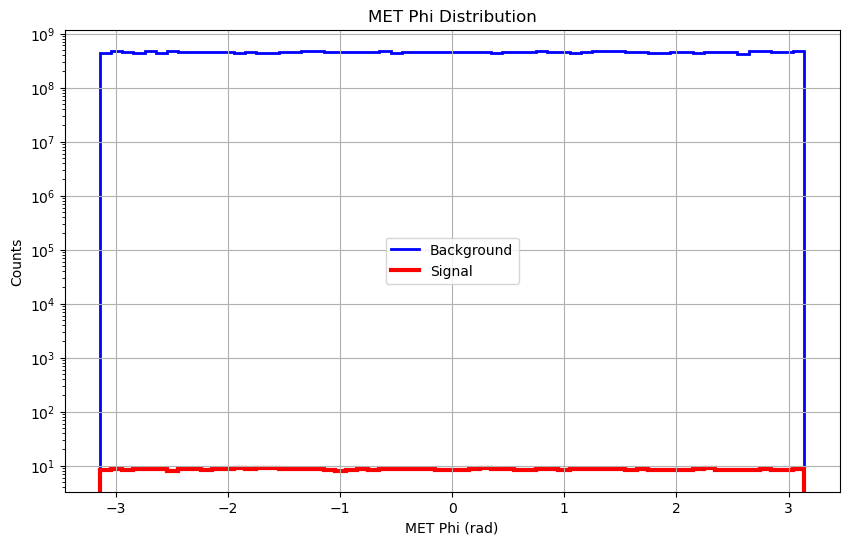

In [110]:
PlotPhiMet(None)

<h2> Jets </h2>

<h3> PT(j0) , PT(j1) </h3>

Num Sig Events before Mask 50000


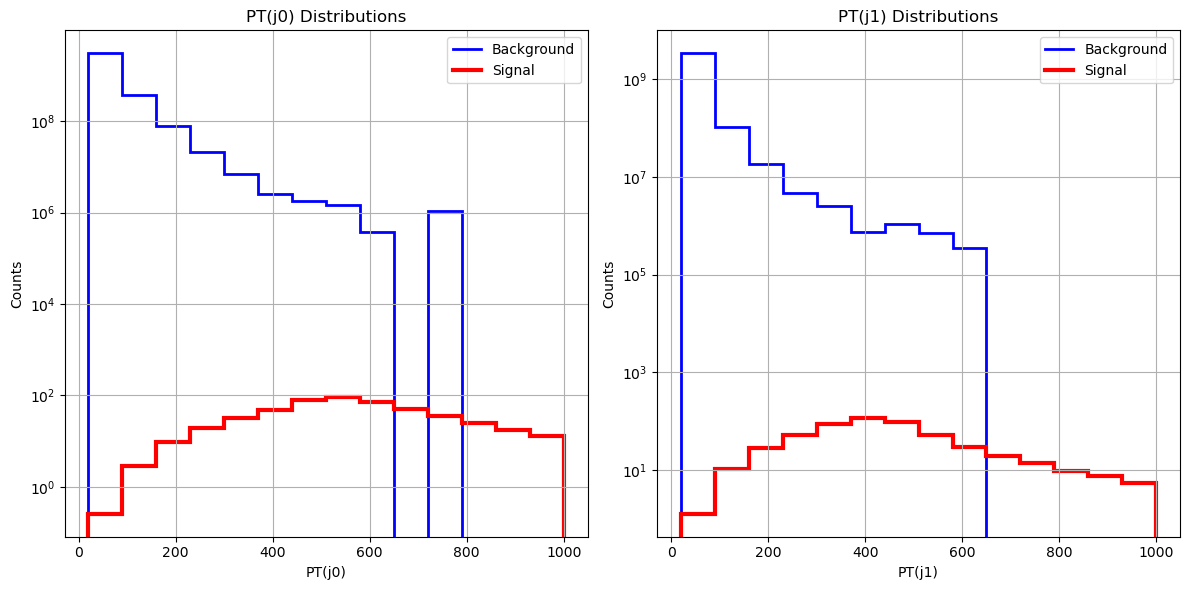

In [111]:
PlotJets("PT","PT",None)

<h3>Phi(J0,J1)</h3>

Num Sig Events before Mask 50000


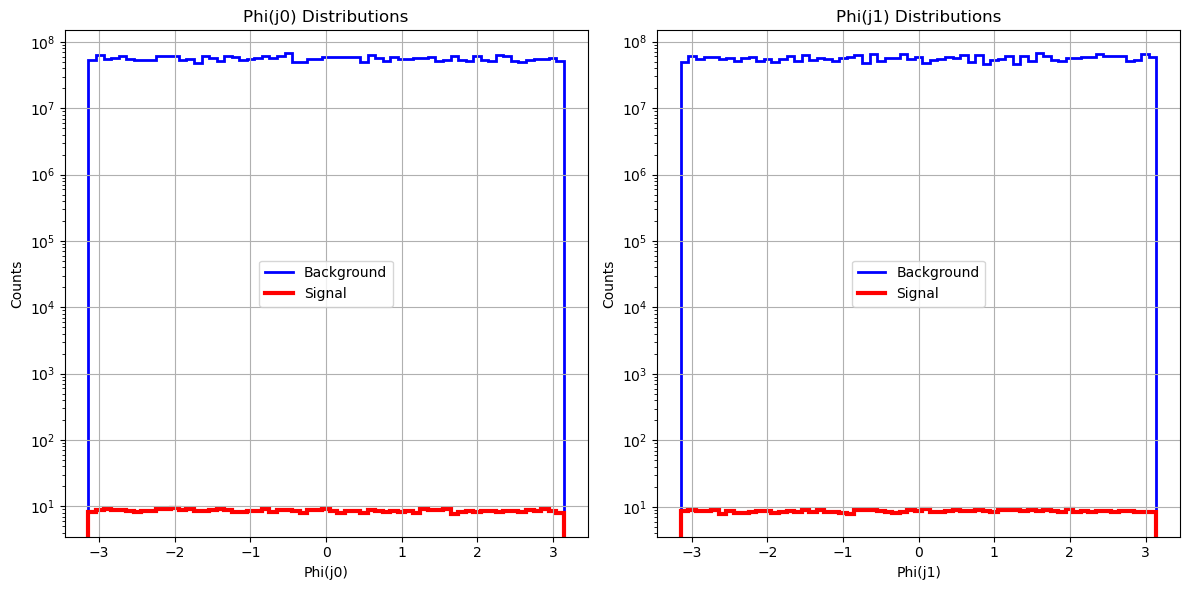

In [112]:
PlotJets("Phi","Phi",None)

<h3> Eta (j0, j1) </h3>

Num Sig Events before Mask 50000


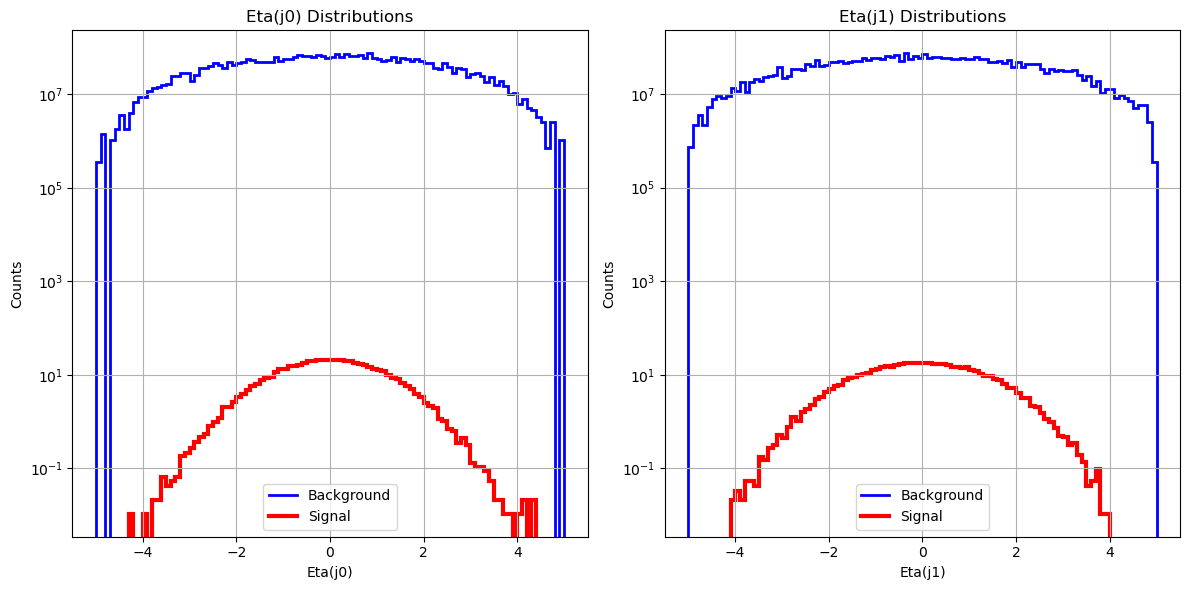

In [113]:
PlotJets("Eta","Eta",None)

<h3>Eta(j0) * Eta(j1)</h3>

In [114]:
def PlotEtaEta(masklist):

    etaeta_hist_background = Hist(
        axis.Regular(binning["Eta*Eta"]["bins"], *binning["Eta*Eta"]["range"], name="Eta*Eta", label="Eta*Eta")
    )
    etaeta_hist_signal = Hist(
        axis.Regular(binning["Eta*Eta"]["bins"], *binning["Eta*Eta"]["range"], name="Eta*Eta", label="Eta*Eta")
    )

    j0sig, j1sig, bkgj0list, bkgj1list, = getJetsData("Eta",masklist)

    etaeta_hist_signal.fill(j0sig*j1sig, weight=signal_weight)

    for i in range(len(background_weight_list)):
        etaeta_hist_background.fill(bkgj0list[i]*bkgj1list[i], weight = background_weight_list[i])


    #Set up histogram
    plt.figure(figsize=(10, 6))

    # Background histogram
    plt.stairs(
        etaeta_hist_background.values(),
        etaeta_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )

    # Signal histogram
    plt.stairs(
        etaeta_hist_signal.values(),
        etaeta_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )

    # Add labels and legend
    plt.xlabel('Eta(j0) * Eta(j1)')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.title('Eta * Eta Distribution')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


    return etaeta_hist_signal, etaeta_hist_background

    

Num Sig Events before Mask 50000


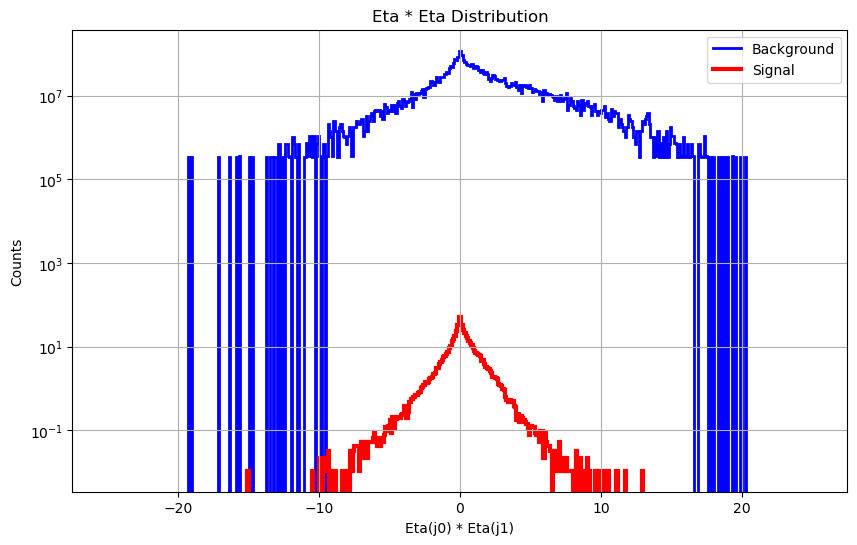

(Hist(Regular(500, -25, 25, name='Eta*Eta'), storage=Double()) # Sum: 540.0000000000041,
 Hist(Regular(500, -25, 25, name='Eta*Eta'), storage=Double()) # Sum: 3554298353.8663263)

In [115]:
PlotEtaEta(None)

<h3> Abs(Delta(J0,J1)) </h3>

In [116]:
def PlotDeltaJets(masklist):

    deltaeta_hist_background = Hist(
        axis.Regular(binning["Delta_Eta"]["bins"], *binning["Delta_Eta"]["range"], name="DeltaEta", label="DeltaEta")
    )

    deltaeta_hist_signal = Hist(
        axis.Regular(binning["Delta_Eta"]["bins"], *binning["Delta_Eta"]["range"], name="DeltaEta", label="DeltaEta")
    )


    j0sig, j1sig, bkgj0list, bkgj1list = getJetsData("Eta",masklist)

    deltaeta_hist_signal.fill(np.abs(j0sig-j1sig), weight=signal_weight)

    for i in range(len(background_weight_list)):
        deltaeta_hist_background.fill(np.abs(bkgj0list[i]-bkgj1list[i]), weight = background_weight_list[i])


    #Set up histogram
    plt.figure(figsize=(10, 6))

    # Background histogram
    plt.stairs(
        deltaeta_hist_background.values(),
        deltaeta_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )

    # Signal histogram
    plt.stairs(
        deltaeta_hist_signal.values(),
        deltaeta_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )

    # Add labels and legend
    plt.xlabel('Abs(Delta Eta) (j0, j1)')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.title('Delta Eta Distribution')
    plt.legend()
    plt.grid(True)


    # Show the plot
    plt.show()


    return deltaeta_hist_signal, deltaeta_hist_background

Num Sig Events before Mask 50000


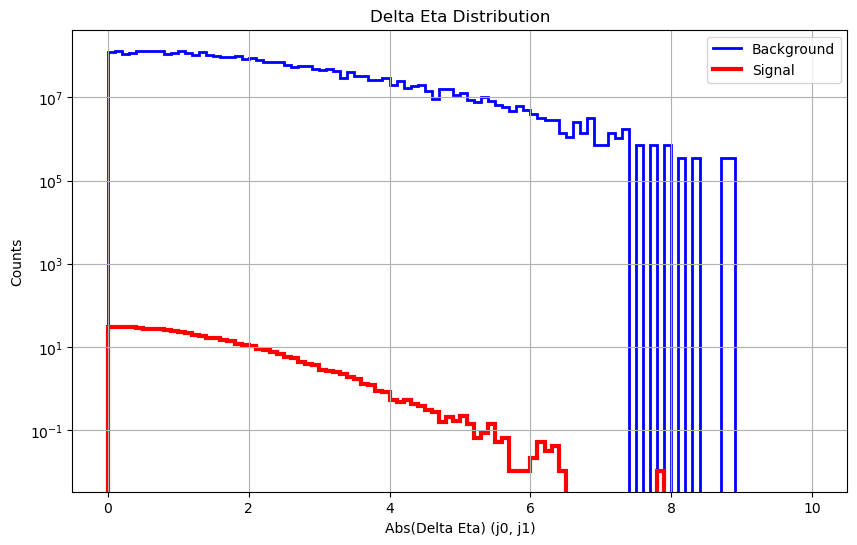

(Hist(Regular(100, 0, 10, name='DeltaEta'), storage=Double()) # Sum: 539.9999999999895,
 Hist(Regular(100, 0, 10, name='DeltaEta'), storage=Double()) # Sum: 3554298353.866342)

In [117]:
PlotDeltaJets(None)

<h3> Invariant Mass (J0 J1) </h3>

In [118]:
def calc_invariant_mass(pt0, eta0, phi0, m0, pt1, eta1, phi1, m1):
    # Energy and momentum components for Jet0
    pz0 = pt0 * np.sinh(eta0)
    e0 = np.sqrt(pt0**2 + pz0**2 + m0**2)
    px0 = pt0 * np.cos(phi0)
    py0 = pt0 * np.sin(phi0)

    # Energy and momentum components for Jet1
    pz1 = pt1 * np.sinh(eta1)
    e1 = np.sqrt(pt1**2 + pz1**2 + m1**2)
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)

    # Invariant mass calculation
    e_total = e0 + e1
    px_total = px0 + px1
    py_total = py0 + py1
    pz_total = pz0 + pz1

    m2 = e_total**2 - (px_total**2 + py_total**2 + pz_total**2)
    m2 = np.maximum(m2, 0)  # This will replace negative values with 0
    return np.sqrt(m2)


In [119]:
def PlotInvariantMass(masklist):

    invariant_hist_background = Hist(
        axis.Regular(binning["Invariant"]["bins"], *binning["Invariant"]["range"], name="Invariant", label="Invariant")
    )

    invariant_hist_signal = Hist(
        axis.Regular(binning["Invariant"]["bins"], *binning["Invariant"]["range"], name="Invariant", label="Invariant")
    )

    #Data needed: pt0, eta0, phi0, m0, pt1, eta1, phi1, m1

    ptj0sig, ptj1sig, ptbkgj0list, ptbkgj1list  = getJetsData("PT",masklist)
    etaj0sig, etaj1sig, etabkgj0list, etabkgj1list = getJetsData("Eta",masklist)
    phij0sig, phij1sig, phibkgj0list, phibkgj1list  = getJetsData("Phi",masklist)
    massj0sig, massj1sig, massbkgj0list, massbkgj1list   = getJetsData("Mass",masklist)

    invariant_hist_signal.fill(
        calc_invariant_mass(pt0=ptj0sig, eta0=etaj0sig, phi0 = phij0sig,m0=massj0sig,
                    pt1=ptj1sig, eta1=etaj1sig, phi1 = phij1sig,m1=massj1sig),
        weight = signal_weight)
    
    total_sig_entries = invariant_hist_signal.sum()

    for i in range(len(background_weight_list)):
        invariant_hist_background.fill(
        calc_invariant_mass(
                    pt0=ptbkgj0list[i], eta0=etabkgj0list[i], phi0 = phibkgj0list[i],m0=massbkgj0list[i],
                    pt1=ptbkgj1list[i], eta1=etabkgj1list[i], phi1 = phibkgj1list[i],m1=massbkgj1list[i]),
                    weight = background_weight_list[i])


    total_bkg_entries = invariant_hist_background.sum()

    print("Total Sig Entries:", total_sig_entries)
    print("Total Bkg Entries:", total_bkg_entries)

    #Set up histogram
    plt.figure(figsize=(10, 6))

    # Background histogram
    plt.stairs(
        invariant_hist_background.values(),
        invariant_hist_background.axes[0].edges,
        color='blue',
        label='Background',
        linewidth=2
    )

    # Signal histogram
    plt.stairs(
        invariant_hist_signal.values(),
        invariant_hist_signal.axes[0].edges,
        color='red',
        label='Signal',
        linewidth=3
    )

    # Add labels and legend
    plt.xlabel('Invariant Mass j0 j1')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.title('Invariant Mass Distribution')
    plt.legend()
    plt.grid(True)


    # Show the plot
    plt.show()

Num Sig Events before Mask 50000
Num Sig Events before Mask 50000
Num Sig Events before Mask 50000
Num Sig Events before Mask 50000
Total Sig Entries: 527.9471999999939
Total Bkg Entries: 3174763323.7125483


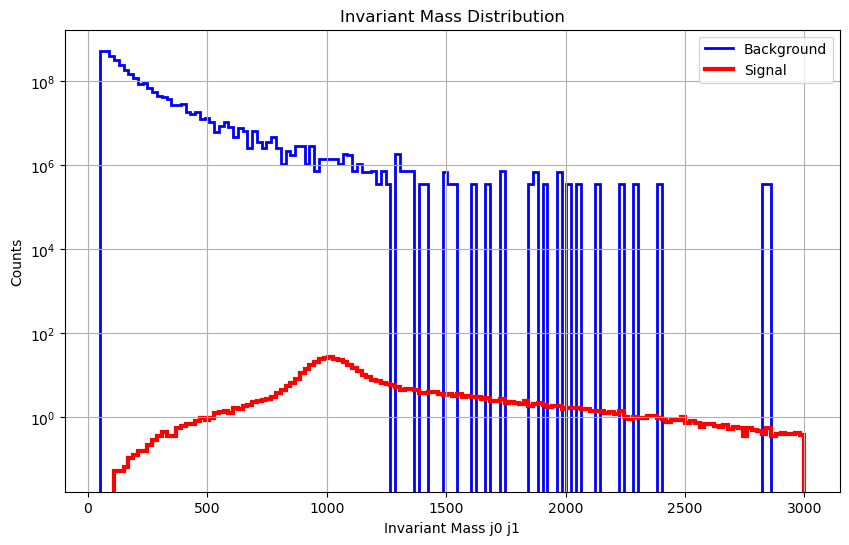

In [120]:
PlotInvariantMass(None)

<h1> Now we start findsing Significance, making Cuts <h1>

In [121]:
#This will store the cuts that we make to our data, sequentially
maskList = []

In [122]:
def GetSignificances(sighist,bkghist):
    signal_counts = sighist.values()
    bkg_counts = bkghist.values()

    significance = []
    for n_s, n_b in zip(signal_counts, bkg_counts):
        if n_b + n_s > 0:
            S = calculateSignificance(numSig=n_s, numBkg=n_b)
            significance.append(S)
        else:
            significance.append(0)  # If both are zero, significance is zero.

    return np.array(significance)



First we will be using $\eta$($j_0$) *  $\eta$($j_1$) to make this cut. 

Num Sig Events before Mask 50000


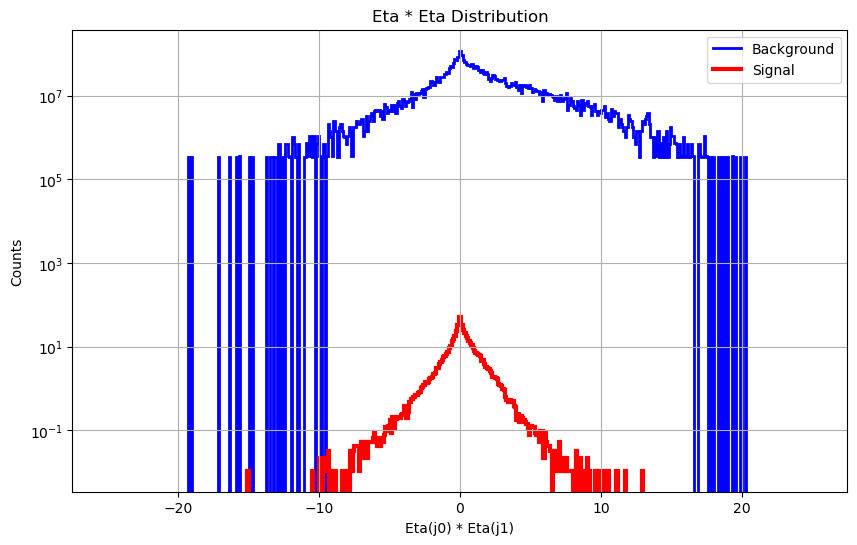

In [123]:
etaeta_sig_hist, etaeta_bkg_hist = PlotEtaEta(None)

<h4> Significance Plot </h4>

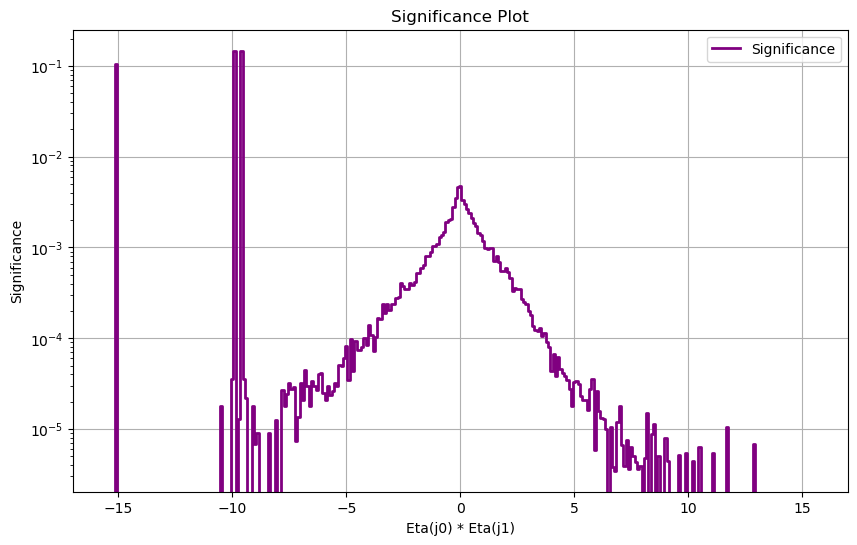

Top 5 Significance Values and Their Corresponding Bins:
Rank 1: Significance = 0.147, Bin = -9.600
Rank 2: Significance = 0.147, Bin = -9.900
Rank 3: Significance = 0.104, Bin = -15.100
Rank 4: Significance = 0.005, Bin = 0.000
Rank 5: Significance = 0.005, Bin = -0.100


In [124]:
significance = GetSignificances(etaeta_sig_hist,etaeta_bkg_hist)

# Get bin edges from the histogram
bin_edges = etaeta_sig_hist.axes[0].edges

# Plot significance
plt.figure(figsize=(10, 6))
plt.step(bin_edges[:-1], significance, where='mid', label='Significance', color='purple', linewidth=2)

# Add labels and title
plt.xlabel('Eta(j0) * Eta(j1)')
plt.xlim(-17, 17)  #from visual inspection
plt.ylabel('Significance')
plt.yscale('log')
plt.title('Significance Plot')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



#Top 5 points
# Find the indices of the top 5 significance values
top_indices = np.argsort(significance)[-5:]  # Get indices of the 5 largest values

# Reverse to get them in descending order
top_indices = top_indices[::-1]

# Retrieve the top 5 significance values and their corresponding bin edges
top_significance_values = significance[top_indices]
top_bin_edges = bin_edges[top_indices]

# Print the top 5 significance values and their corresponding bins
print("Top 5 Significance Values and Their Corresponding Bins:")
for i, idx in enumerate(top_indices):
    print(f"Rank {i + 1}: Significance = {top_significance_values[i]:.3f}, Bin = {top_bin_edges[i]:.3f}")


We chose cut to be eta(j0)*eta(j1) >= 0 

In [125]:
def mask_etaeta_condition(df):
    # Extract Eta for j0 and j1
    eta_j0 = df["Jet.Eta"].apply(lambda x: x[0] if len(x) > 0 else None)
    eta_j1 = df["Jet.Eta"].apply(lambda x: x[1] if len(x) > 1 else None)

    # Create mask where Eta(j0) * Eta(j1) >= 0
    return (eta_j0 * eta_j1) >= 0

maskList.append(mask_etaeta_condition)

Now we will plot invariable mass after making this cut

Num Sig Events before Mask 50000
Num Sig Events AFTER Mask 27200
Num Sig Events before Mask 50000
Num Sig Events AFTER Mask 27200
Num Sig Events before Mask 50000
Num Sig Events AFTER Mask 27200
Num Sig Events before Mask 50000
Num Sig Events AFTER Mask 27200
Total Sig Entries: 292.26959999999735
Total Bkg Entries: 1912273198.8281875


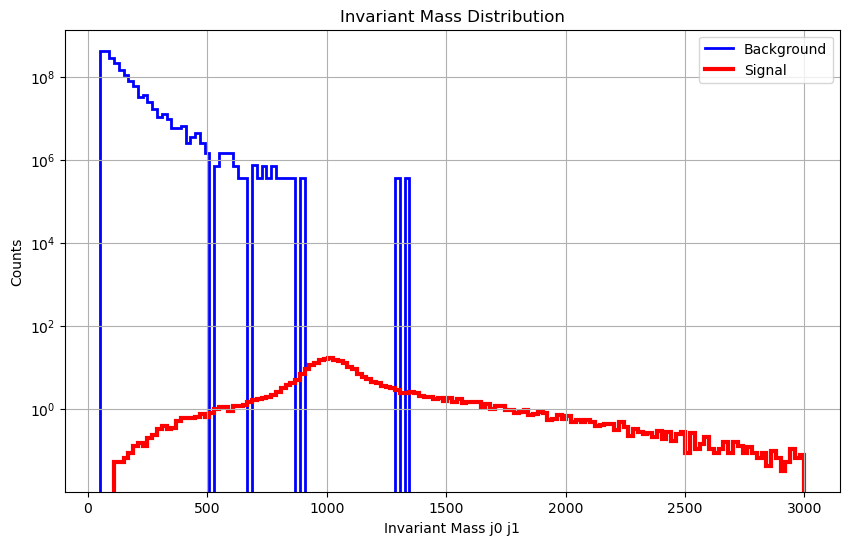

In [126]:
PlotInvariantMass(maskList)

<b> abs($\Delta$($j_0$,$j_1$)) </b>

Now we will use Delta(J0,J1) to make the next cut. Let's plot it with our current cuts

Num Sig Events before Mask 50000
Num Sig Events AFTER Mask 27200


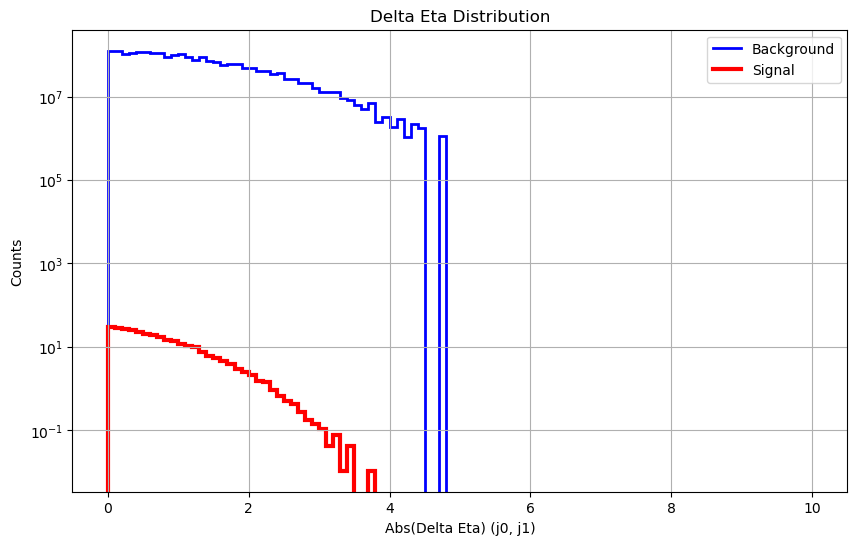

In [127]:
deltaeta_sig_hist , deltaeta_bkg_hist = PlotDeltaJets(maskList)

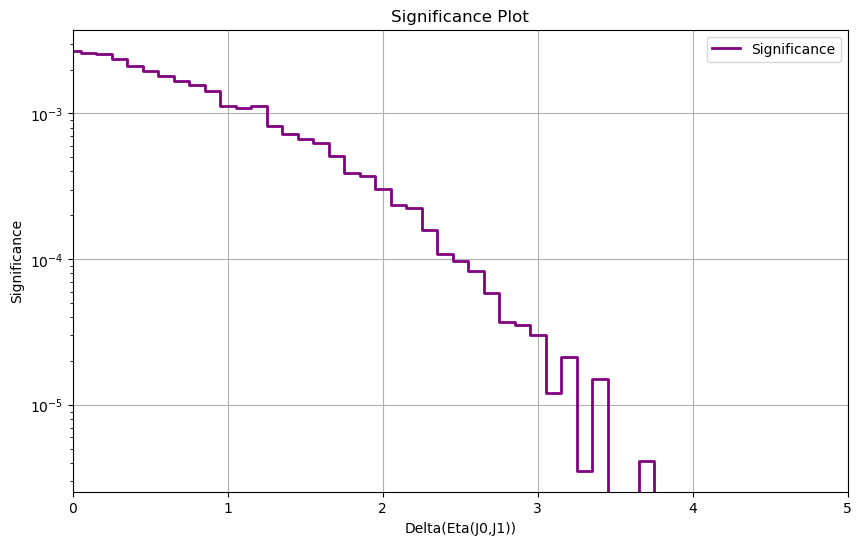

Top 5 Significance Values and Their Corresponding Bins:
Rank 1: Significance = 0.003, Bin = 0.000
Rank 2: Significance = 0.003, Bin = 0.100
Rank 3: Significance = 0.003, Bin = 0.200
Rank 4: Significance = 0.002, Bin = 0.300
Rank 5: Significance = 0.002, Bin = 0.400


In [128]:
significance = GetSignificances(deltaeta_sig_hist,deltaeta_bkg_hist)

# Get bin edges from the histogram
bin_edges = deltaeta_sig_hist.axes[0].edges

# Plot significance
plt.figure(figsize=(10, 6))
plt.step(bin_edges[:-1], significance, where='mid', label='Significance', color='purple', linewidth=2)

# Add labels and title
plt.xlabel('Delta(Eta(J0,J1))')
plt.xlim(0, 5)  #from visual inspection
plt.ylabel('Significance')
plt.yscale('log')
plt.title('Significance Plot')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()



#Top 5 points
# Find the indices of the top 5 significance values
top_indices = np.argsort(significance)[-5:]  # Get indices of the 5 largest values

# Reverse to get them in descending order
top_indices = top_indices[::-1]

# Retrieve the top 5 significance values and their corresponding bin edges
top_significance_values = significance[top_indices]
top_bin_edges = bin_edges[top_indices]

# Print the top 5 significance values and their corresponding bins
print("Top 5 Significance Values and Their Corresponding Bins:")
for i, idx in enumerate(top_indices):
    print(f"Rank {i + 1}: Significance = {top_significance_values[i]:.3f}, Bin = {top_bin_edges[i]:.3f}")


We chose our latest cut to be:

<b>Pt($j_0$) </b>

<b>Pt($j_1$)</b>

<b> $M_{ET}$, <b>

<h1>Step 5: Compile full Cut Chart </h1>

In [129]:

column_width = 12  

# Create the grid header
header_row = f"{'Cut #':^{column_width}} | {'SM Events':^{column_width}} | {'NP Events':^{column_width}} | {'Significance':^{column_width}}"
print(header_row)

# Print a separator line
print("-" * (len(header_row) + 1))

#Initial Conditions
init_data = f"{'    Init':{column_width}} | {SM_events[0]:^{column_width}} | {NP_events[0]:^{column_width}} | {Significance[0]:^{column_width}.2f}"  # 
print(init_data)

# Iterate through data and format each row
for i in range(1, num_cuts):  # Use range(1, num_cuts+1) for 1 to num_cuts (inclusive)
    row_data = f"{i:{column_width}} | {SM_events[i]:^{column_width}} | {NP_events[i]:^{column_width}} | {Significance[i]:^{column_width}.2f}" 
    print(row_data)




   Cut #     |  SM Events   |  NP Events   | Significance
----------------------------------------------------------
    Init     |     1000     |     500      |     1.00    
           1 |     700      |     400      |     2.40    
           2 |     200      |     300      |     5.00    


IndexError: list index out of range

<h2> CODE TESTING </h2>

In [ ]:
def mask_pt_j0_greater_than_30(df):
    # Extract PT for j0
    pt_j0 = df["Jet.PT"].apply(lambda x: x[0] if len(x) > 0 else None)
    
    # Create mask where PT(j0) > 30
    return pt_j0 > 550


def mask_eta_condition(df):
    # Extract Eta for j0 and j1
    eta_j0 = df["Jet.Eta"].apply(lambda x: x[0] if len(x) > 0 else None)
    eta_j1 = df["Jet.Eta"].apply(lambda x: x[1] if len(x) > 1 else None)

    # Create mask where Eta(j0) * Eta(j1) >= 0
    return (eta_j0 * eta_j1) >= 0